In [54]:
import os
from tempfile import tempdir
from time import time
from turtle import color
from unittest.mock import NonCallableMagicMock
import pandas as pd
import numpy as np
import warnings
import math
import re

import seaborn as sns
warnings.filterwarnings("ignore")

import sys
sys.path.append("./")

from pathlib import Path

import tqdm
import importlib

import matplotlib.pyplot as plt
# from PySide2.QtWidgets import QFileDialog, QApplication
# from PySide2.QtCore import Qt
from copy import copy 

from corems.mass_spectra.input import rawFileReader
from corems.molecular_id.factory.classification import HeteroatomsClassification, Labels
from corems.molecular_id.search.priorityAssignment import OxygenPriorityAssignment
from corems.molecular_id.search.molecularFormulaSearch import SearchMolecularFormulas
from corems.encapsulation.factory.parameters import MSParameters
from corems.encapsulation.constant import Atoms
from corems.mass_spectrum.calc.Calibration import MzDomainCalibration

import corems.lc_icpms_ftms.calc.lc_icrms_qc_assign as icrms
import corems.lc_icpms_ftms.calc.lc_icrms_helpers as lcmsfns

import importlib

from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)




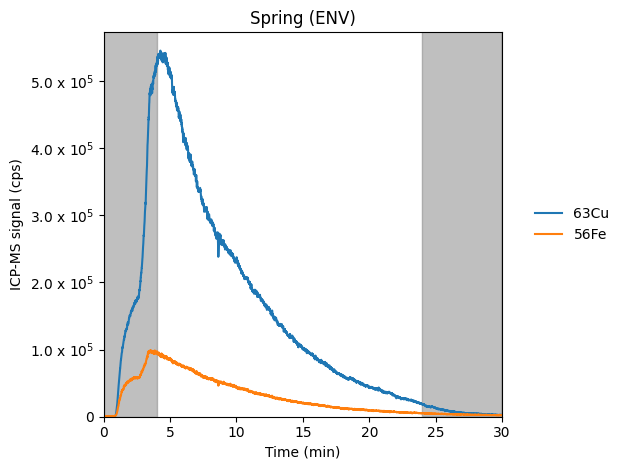

In [29]:
from matplotlib.backends.backend_pdf import PdfPages

icpms_file = '/Users/christiandewey/Library/CloudStorage/Box-Box/Boiteau Lab/Mass Spec Data/Keck iCAP Q/2022/2022-09/Tillamook, Sept 2022/spring_env.csv'
icpms = pd.read_csv(icpms_file, sep=';',header=1)


metals = ['63Cu','56Fe']

fig, ax = plt.subplots()

maxicp = 0 
for me in metals:
    me_key = 'Time %s' %me
    ax.plot(icpms[me_key]/60, icpms[me], label=me)        
    



#ax.set_ylim(0,maxicp*1.1)
ax.set_title('Spring (ENV)')
ax.set_xlabel('Time (min)')
ax.set_ylabel('ICP-MS signal (cps)')
ax.legend(bbox_to_anchor=(1.05,0.5),loc='center left',frameon =False)
ax.set_xlim(0,30)
ax.set_ylim(bottom = 0)

x = np.arange(0.0, 4, 0.01)
ax.fill_between(x, 0,1e6,  color = 'gray',alpha=0.5)
x = np.arange(24, 30, 0.01)
ax.fill_between(x, 0,1e6, color = 'gray', alpha=0.5)
current_yvalues = plt.gca().get_yticks()
ylabs = []
for y in current_yvalues:
    if y == 0:
        d = int(0)
    else:
        d = '{:.1f} x $10^5$'.format(y/1e5)
    ylabs.append(d)
#plt.gca().set_yticklabels(['{:.1f} x $10^5$'.format(y/1e5) for y in current_yvalues])
plt.gca().set_yticklabels(ylabs)
fig.tight_layout()
plt.show()

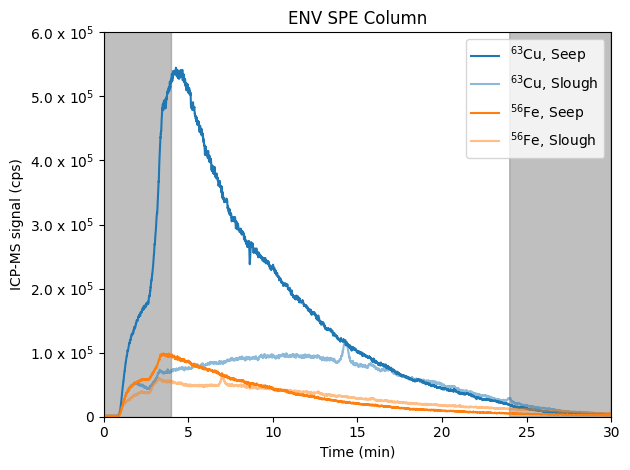

In [59]:
from matplotlib.backends.backend_pdf import PdfPages

flist = ['spring_env.csv','slough_env.csv']
title = 'ENV SPE Column'
#flist = ['spring_ppl.csv','slough_ppl.csv']
#title = 'PPL SPE Column'
labels = ['Seep', 'Slough']
alphas = [1,0.5]
labs = {f:l for f,l in zip(flist,labels)}
transp = {f:a for f,a in zip(flist,alphas)}

dir = '/Users/christiandewey/Library/CloudStorage/Box-Box/Boiteau Lab/Mass Spec Data/Keck iCAP Q/2022/2022-09/Tillamook, Sept 2022/'

metals = ['63Cu','56Fe']
colors = ['C0', 'C1']
cols = {m:c for m,c in zip(metals,colors)}


fig, ax = plt.subplots()

for me in metals:

    maxicp = 0 

    for f in flist:

        icpms_file = dir + f
        icpms = pd.read_csv(icpms_file, sep=';',header=1)
        mw = me[:2]
        sym = me[2:]
        plab = '$^{%s}$%s' %(mw,sym)
        me_key = 'Time %s' %me
        ax.plot(icpms[me_key]/60, icpms[me], label=plab+', '+labs[f],color = cols[me], alpha = transp[f])        
        

#ax.set_ylim(0,maxicp*1.1)
ax.set_title(title)
ax.set_xlabel('Time (min)')
ax.set_ylabel('ICP-MS signal (cps)')
#ax.legend(bbox_to_anchor=(1.05,0.5),loc='center left',frameon =False)
ax.legend(bbox_to_anchor=(1.0,1.0),loc='upper right')

ax.set_xlim(0,30)
ax.set_ylim(bottom = 0, top = 6e5)
ax.yaxis.set_major_locator(MultipleLocator(1e5))

x = np.arange(0.0, 4, 0.01)
ax.fill_between(x, 0,1e6,  color = 'gray',alpha=0.5)
x = np.arange(24, 30, 0.01)
ax.fill_between(x, 0,1e6, color = 'gray', alpha=0.5)
current_yvalues = plt.gca().get_yticks()
ylabs = []
for y in current_yvalues:
    if y == 0:
        d = int(0)
    else:
        d = '{:.1f} x $10^5$'.format(y/1e5)
    ylabs.append(d)
#plt.gca().set_yticklabels(['{:.1f} x $10^5$'.format(y/1e5) for y in current_yvalues])
plt.gca().set_yticklabels(ylabs)


fig.tight_layout()
plt.show()

In [80]:
from tabulate import tabulate
geochem = pd.DataFrame(columns = ['Seep', 'Slough'], index = ['pH', 'Conductivity (mS/cm)','DO (mg/L)','T (C)','Total Cu (uM)', 'Total Fe (uM)', 'DOC (mM)'])

seep = [5.5, 1000,0.1, 8, 100,200,4]
slough = [7.2, 200,8, 8, 50,100,3]

geochem['Seep'] = seep
geochem['Slough'] = slough

geochem

ctest = tabulate(geochem, headers=['Seep', 'Slough'], tablefmt='latex')




/Users/christiandewey/CoreMS


sh: pdflatex: command not found


32512

In [ ]:
alldf = pd.concat([unique_fullmz_456, unique_100mz_456])
#alldf = unique_100mz_456

times = data_df['Time'].unique()

holder = {}
summary = []
summary2 = []

for mzw in alldf['m/z Window Size'].unique():
    
    sub1 = alldf[alldf['m/z Window Size'] == mzw]

    for t in times:
        
        print(mzw)
        lsh = {}
        lsh['m/z Window Size'] = mzw

        sub2 = sub1[sub1['Time'] == t]

        sub2 = sub2[sub2['S/N'] > 3]
        
        dynamic_range_t = max(sub2['Peak Height']/min(sub2['Peak Height']))
        
        lsh['Time'] = t
        lsh['Dynamic Range'] = dynamic_range_t        
        lsh['n Features'] = len(sub2)
        lsh['Max I'] = max(sub2['Peak Height'])
        lsh['Min I'] = min(sub2['Peak Height'])
        summary.append(lsh)


df=pd.DataFrame(summary)

sns.boxplot(data=df, x="Dynamic Range", y="m/z Window Size")

In [ ]:

pdf = PdfPages('/Users/christiandewey/Library/CloudStorage/Box-Box/data/assignments/spring/eics_cu_100mz_fullmz-dec13.pdf')

fig, ax = plt.subplots()

maxicp = 0 
for me in metals:
    me_key = 'Time %s' %me
    ax.plot(icpms[me_key]/60, icpms[me], label=me)        
    



#ax.set_ylim(0,maxicp*1.1)
ax.set_title('Cu ICPMS Trace')
ax.set_xlabel('Time (min)')
ax.set_ylabel('ICPMS signal (cps)')
ax.legend(bbox_to_anchor=(1.05,0.5),loc='center left',frameon =False)
ax.set_xlim(2,30)
fig.tight_layout()
pdf.savefig()

for mf in mz100_EICdic:   

    fig, ax = plt.subplots()
    
    eict=mz100_EICdic[mf].time
    eics=mz100_EICdic[mf].eic

    inds = np.where(np.asarray(eict)<28)

    eict = np.asarray(eict)[inds]
    eics = np.asarray(eics)[inds]

    ax.plot(eict, eics,color = 'red', label=r'$\Delta$m/z 100 window')

    if mf in fullmz_EICdic:
        eic2t = fullmz_EICdic[mf].time
        eic2s = fullmz_EICdic[mf].eic

        eic2t = np.asarray(eic2t)[inds]
        eic2s = np.asarray(eic2s)[inds]
        ax.plot(eic2t,eic2s, color ='C0', label = 'full window')
    ax.set_xlim(4,28)
    ax.set_title(mf)
    ax.legend(frameon = False,bbox_to_anchor=(1.05,0.5),loc='center left')
    fig.tight_layout()
    pdf.savefig()

for mf in fullmz_EICdic:   

    if mf not in mz100_EICdic:

        fig, ax = plt.subplots()

        eic2t = fullmz_EICdic[mf].time
        eic2s = fullmz_EICdic[mf].eic

        inds = np.where(np.asarray(eic2t)<28)

        eic2t = np.asarray(eic2t)[inds]
        eic2s = np.asarray(eic2s)[inds]
        ax.plot(eic2t,eic2s, color ='C5', label = 'full window')

        ax.set_xlim(4,28)
        ax.set_title(mf)
        ax.legend(frameon = False,bbox_to_anchor=(1.05,0.5),loc='center left')
        fig.tight_layout()
        pdf.savefig()

pdf.close()